# Rebinning opacities

pRT has two different intrinsic opacity treatments. One makes use of the so-called correlated-k method (`c-k`), and allows you to calculate spectra at a wavelength binning of $\lambda / \Delta \lambda = 1000$. The other is the so-called line-by-line method (`lbl`), and allows you to calculate specra at $\lambda / \Delta \lambda = 10^6$.

Sometimes you want to calculate spectra at a larger wavelength spacing, however, say at $\lambda / \Delta \lambda = 150$ in the `c-k` mode, or at $\lambda / \Delta \lambda = 250,000$ in `lbl` mode. Of course it is possible to run calculations at high intrinsic resolution first, and then bin down, but this is numerically inefficient. This is why you can easily specify lower resolutions in the retrieval subpackage of pRT, [see the tutorial here](../basic_retrieval.html). Here we show you how to do access these routines outside of the retrieval subpackage.

## Rebinning `c-k` opacities

To rebin `c-k` opacities to a target spacing $\leq 1000$ just create a pRT object as usual, but only specify the line species you want to rebin. **Do not change the wavelength bounds below for the rebinning, please keep them at** `wlen_bords_micron = [0.1, 251.]`.

In [1]:
import numpy as np

from petitRADTRANS import Radtrans

species = ['CH4', 'PH3', 'NH3']

atmosphere = Radtrans(line_species = species,
                      wlen_bords_micron = [0.1, 251.]) # DO NOT CHANGE THESE WAVELENGTH BOUNDS FOR THE REBINNING!

/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/radtrans.py:103: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  FutureWarning)


  Read line opacities of CH4...
 Done.
  Read line opacities of PH3...
 Done.
  Read line opacities of NH3...
 Done.



Next we need to specify the masses of the molecules to be rebinned in atomic mass units (CH$_4$  has a mass of 16,  for example).  This is easily done with the [molmass package](https://pypi.org/project/molmass/). 

In [ ]:
from molmass import Formula

masses = {}
for spec in species:
    f = Formula(spec)
    masses[spec] = f.isotope.massnumber
    
print(masses)

{'CH4': 16, 'PH3': 34, 'NH3': 17}


Now we rebin, we chose a target wavelength binning of $\lambda/\Delta\lambda=150$, and save the results in folder we aptly call `rebin_test`.  pRT uses the [exo-k](https://pypi.org/project/exo-k/) package for this.

In [3]:
atmosphere.write_out_rebin(150,
                           path='rebin_test',
                           species = species,
                           masses = masses)

Rebinning species CH4...
Rebinning species PH3...
Rebinning species NH3...


Now just install the opacities by placing the folders inside the rebin test folder (`CH4_R_150`, `NH3_R_150`, `PH3_R_150`) into pRTs input data folder, that is, into `input_data/opacities/lines/corr_k/`. You are done! The species `CH4_R_150`, `NH3_R_150`, `PH3_R_150`  are now ready to use in pRT. Lets compare the old high and new lower resolution opacities:

In [4]:
atmosphere_high_res = Radtrans(line_species = ['CH4', 'PH3', 'NH3'],
                      rayleigh_species = ['H2','He'],
                      wlen_bords_micron = [0.5, 10.])

atmosphere_low_res = Radtrans(line_species = ['CH4_R_150', 'PH3_R_150', 'NH3_R_150'],
                      rayleigh_species = ['H2','He'],
                      wlen_bords_micron = [0.5, 10.])

/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/radtrans.py:103: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  FutureWarning)


  Read line opacities of CH4...
 Done.
  Read line opacities of PH3...
 Done.
  Read line opacities of NH3...
 Done.

  Read line opacities of CH4_R_150...
 Done.
  Read line opacities of PH3_R_150...
 Done.
  Read line opacities of NH3_R_150...
 Done.



We just copy some transmission spectrum example from the tutorial in here to compare spectra:

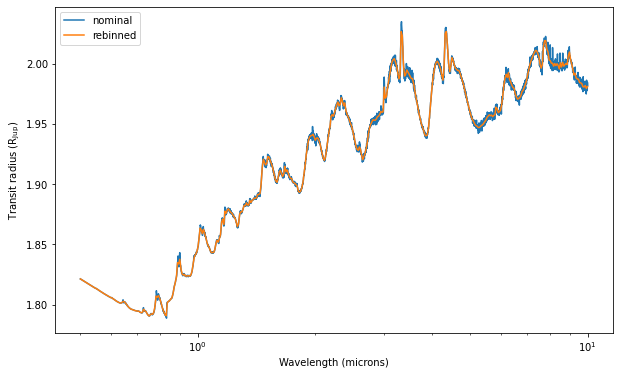

In [5]:
pressures = np.logspace(-6, 2, 100)
atmosphere_high_res.setup_opa_structure(pressures)
atmosphere_low_res.setup_opa_structure(pressures)
temperature = 1200. * np.ones_like(pressures)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.001 * np.ones_like(temperature)
mass_fractions['NH3'] = 0.001 * np.ones_like(temperature)
mass_fractions['PH3'] = 0.001 * np.ones_like(temperature)
mass_fractions['CH4_R_150'] = 0.001 * np.ones_like(temperature)
mass_fractions['NH3_R_150'] = 0.001 * np.ones_like(temperature)
mass_fractions['PH3_R_150'] = 0.001 * np.ones_like(temperature)

MMW = 2.33 * np.ones_like(temperature)

from petitRADTRANS import nat_cst as nc
R_pl = 1.838*nc.r_jup_mean
gravity = 1e1**2.45
P0 = 0.01

atmosphere_high_res.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)
atmosphere_low_res.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)

import pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(nc.c/atmosphere_high_res.freq/1e-4, 
         atmosphere_high_res.transm_rad/nc.r_jup_mean, 
         label = 'nominal')
plt.plot(nc.c/atmosphere_low_res.freq/1e-4, 
         atmosphere_low_res.transm_rad/nc.r_jup_mean,
         label = 'rebinned')

plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.legend(loc = 'best')
plt.show()

<div class="alert alert-warning">

Please note: **NEVER** mix line opacities of different resolutions for a single pRT object!

</div>

## Downsampling `lbl` opacities

In the line-by-line mode it is enough to just specify the desired downsampling factor. As pRT intrinsically has a spacing of $\lambda / \Delta \lambda = 10^6$, a spacing of $\lambda / \Delta \lambda = 250,000$ can be achieved when requesting a downsampling factor of $10^6/250,000 = 4$. This is then done by setting `lbl_opacity_sampling = 4` when creating the pRT object. We compare a nominal and downsampled case below, again by copying the tutorial:

In [6]:
atmosphere_high_res = Radtrans(line_species = ['H2O_main_iso',
                                      'CO_all_iso',
                                      'CH4_main_iso',
                                      'CO2_main_iso',
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [2.2, 2.4],
                      mode = 'lbl')

atmosphere_low_res = Radtrans(line_species = ['H2O_main_iso',
                                      'CO_all_iso',
                                      'CH4_main_iso',
                                      'CO2_main_iso',
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [2.2, 2.4],
                      lbl_opacity_sampling = 4,
                      mode = 'lbl')

pressures = np.logspace(-10, 2, 130)
atmosphere_high_res.setup_opa_structure(pressures)
atmosphere_low_res.setup_opa_structure(pressures)

/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/radtrans.py:103: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  FutureWarning)



  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [7]:
from petitRADTRANS.physics import guillot_global

R_pl = 1.838*nc.r_jup_mean
gravity = 1e1**2.45
P0 = 0.01

kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.
temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O_main_iso'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso'] = 0.01 * np.ones_like(temperature)
mass_fractions['CO2_main_iso'] = 0.00001 * np.ones_like(temperature)
mass_fractions['CH4_main_iso'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Na'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K'] = 0.000001 * np.ones_like(temperature)

MMW = 2.33 * np.ones_like(temperature)

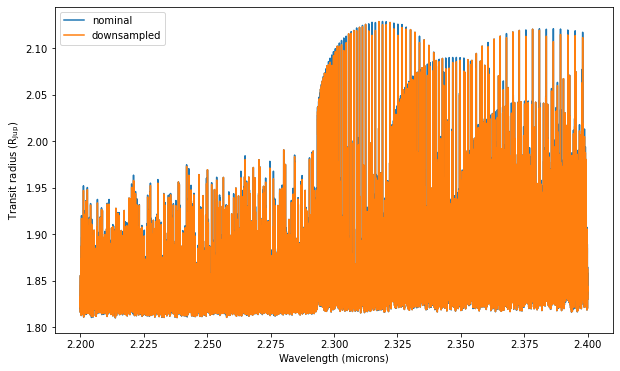

In [8]:
atmosphere_high_res.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)
atmosphere_low_res.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)

import pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(nc.c/atmosphere_high_res.freq/1e-4, 
         atmosphere_high_res.transm_rad/nc.r_jup_mean,
         label = 'nominal')
plt.plot(nc.c/atmosphere_low_res.freq/1e-4,
         atmosphere_low_res.transm_rad/nc.r_jup_mean,
         label = 'downsampled')

plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.legend(loc = 'best')
plt.show()

Zooming in a bit:

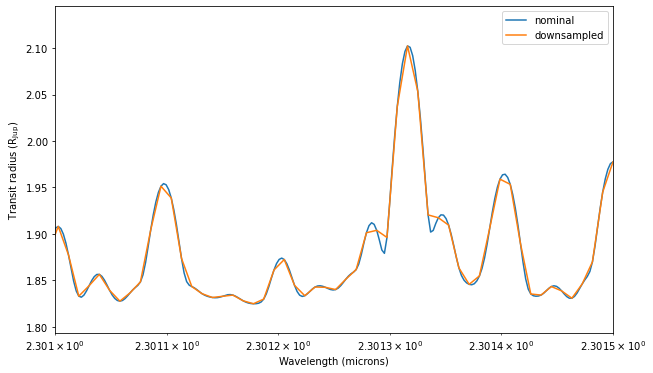

In [9]:
plt.plot(nc.c/atmosphere_high_res.freq/1e-4, 
         atmosphere_high_res.transm_rad/nc.r_jup_mean,
         label = 'nominal')
plt.plot(nc.c/atmosphere_low_res.freq/1e-4,
         atmosphere_low_res.transm_rad/nc.r_jup_mean,
         label = 'downsampled')

plt.xlim([2.301,2.3015])
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.legend(loc = 'best')
plt.show()

<div class="alert alert-warning">

Please always check that the difference between the downsampled spectrum and the spectrum at nominal resolution is negligible when both are binned down to the actual resolution of the data that you want to compare to.

</div>